## Домашнее задание

Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками с помощью BigARTM**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases, можно также попробовать другие способы построить нграммы); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно - из словаря можно просто вручную или правилом удалять строки, при загрузке ничего не сломается); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейке нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **

In [97]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim, nltk
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

In [98]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/nata/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

def clean(words):
    clean = [morph.parse(word)[0].normal_form for word in words if word.isalnum()]
    return clean

## Возьмем те же данные

In [4]:
habr_texts = [clean(word_tokenize(remove_tags(text.lower()))) for text in open('habr_texts.txt')]

In [5]:
# вернемся сюда через какое-то время
# ph = gensim.models.Phrases(habr_texts, scoring='npmi', threshold=0.3, 
#                            common_terms=set(stopwords.words('russian'))) # можно указать слова, которые 
                                                                          # не будут учитываться
# p = gensim.models.phrases.Phraser(ph)
# ngrammed_habr_texts = p[habr_texts]

In [6]:
# p[habr_texts[1]]

**Немного изменим предобработку текстов (воспользуемся `mystem` и удалим "мусор")**

In [99]:
import warnings
warnings.filterwarnings("ignore")

In [100]:
from string import punctuation
from pymystem3 import Mystem

In [101]:
russian_stopwords = set(stopwords.words('russian')) | {'gt',} | {'lt',} | {'if',} | {'for',}

In [102]:
punct = punctuation + '«»—…“”*№–'
mystem = Mystem()

In [103]:
def preprocessing(text):
    text = re.sub('\s{2,}', '', text)
    regex = re.compile('[^a-zA-ZА-Яа-я]') # );\t}\t -- достаточно много подобных сочетаний различных символов
    text = regex.sub(' ', text)
    tokens = mystem.lemmatize(text)
    tokens = [token for token in tokens if token not in russian_stopwords \
              and token != ' '  \
              and token.strip() not in punct \
              and len(token) > 2]
    
    return tokens

In [104]:
texts = open('habr_texts.txt').read().splitlines()

In [105]:
texts = [preprocessing(remove_tags(text.lower())) for text in texts]

Для BigARTM требуется специальный формат данных. Их несколько, но мы возьмем vowpal wabbit.  
На каждой строчке файла находится одельный текст, записывается такст вот таким образом:  
```doc_name |@class_id word_1:1 word_2:3```  

|@class_id - задает модальность, но когда она одна её можно не указывать.

word_2:3 - слово и его частота (обратите внимание, что : - специальный символ и в словах его быть не может

In [107]:
f = open('habr_texts.vw', 'w')

for i, text in enumerate(texts):
    c = Counter(text)
    doc = 'doc_' + str(i) + ' '
    vw_text = ' '.join([x + ':' + str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()

Для оценки будем использовать такую функцию (из туториалов от создателей библиотеки)

In [108]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()

BigARTM работает не с целым файлом, а с кусочками. Поэтому разбиваем наш .vw файл специальным классом в artm.

In [109]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                        batch_size=1000) # размер батча, подбирайте под свою память

Уже созданные батчи можно заново загружать

In [110]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

In [111]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

Собираем словарь по батчам

In [112]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)

artm.Dictionary(name=3fd67e4b-61d1-42ea-a429-1538b65eb0b1, num_entries=15117)

Его можно сохранить, чтобы не создавать снова или чтобы посмотреть и подредактировать.

In [113]:
dictionary.save_text('dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

**Посмотрим на словарь**

In [181]:
with open('dict.txt', 'r', encoding='utf-8') as f:
    f = f.read().splitlines()

In [182]:
f[:10]

['name: 3fd67e4b-61d1-42ea-a429-1538b65eb0b1 num_items: 4121',
 'token, class_id, token_value, token_tf, token_df',
 'шоппинг, @default_class, 5.192651315155672e-06, 19.0, 16.0',
 'зато, @default_class, 0.0001106854688259773, 405.0, 333.0',
 'priority, @default_class, 2.213709376519546e-05, 81.0, 42.0',
 'условно, @default_class, 4.31809967267327e-05, 158.0, 105.0',
 'username, @default_class, 0.00011724460637196898, 429.0, 95.0',
 'правило, @default_class, 0.0005933287320658565, 2171.0, 981.0',
 'experience, @default_class, 1.4758062206965405e-05, 54.0, 37.0',
 'выгорать, @default_class, 5.465949016070226e-06, 20.0, 16.0']

**В словаре достаточно часто встречаются 2-буквенные сочетания (th, xx и др.), удалим их (в предобработке изменим `len(token) > 1` на `len(token) > 2`). В остальном, благодаря предобработке текстов, словарь получился без большого количества "мусора".**

Создаем модель и сразу включаем два регуляризатора (Декореляции и Сглаживания)

`artm.DecorrelatorPhiRegularizer` - регуляризатор декорреляции тем, делает темы менее похожими друг на друга (рекомендуется включать его сразу на всех темах с положительным значением tau и не менять его в процессе обучения)  

`artm.SmoothSparsePhiRegularizer` - регуляризатор сглаживания/разреженивания Phi (тем) - сглаживает или расреживает распределение слов в темах (отрицательный tau - разреживает, положительный - сглаживает), рекомендуется сразу включать сглаживание на всех темах и не менять его в процессе обучения;

Количество тем нужно подбирать, но 200 часто работает хорошо. Снижение количества тем и уменьшения словаря ведут к уменьшению времени обучения модели (а увеличение, наоборот). 

In [116]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [117]:
# инициализурем модель словарем
model_artm.initialize(dictionary=dictionary, )

In [118]:
# добавляем метрики
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

### Тренируем модель

Пройдемся несколько раз по коллекции, чтобы модель немного сошлась (если доков сильно больше то может быть достаточно и 1 прохода). Для сильно больших коллекций есть fit_online, который обновляется в процессе прохода по коллекции, про него можно почитать в документации.

In [119]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.001 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 4723.270 (ARTM)


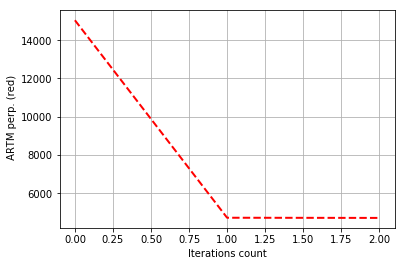

In [120]:
# посмотрим, что стало с моделью
# если график сильно падал на последних итерациях, то можно прогнать обучение ещё несколько раз 
# (не добавляя другие регуляризаторы)
print_measures(model_artm)

Добавим регуляризаторы разреженности тем и документов.

Их рекомендуется добавлять после того, как модель уже как-то сошлась. После добавления их рекомендуется постепенно уменьшать, чтобы усиливать разреживание. Их можно применять не ко всем темам, чтобы в каких-то темах собрались все стоп-слова.

Можно добавлять их вместе или по отдельности.

In [121]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [122]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [123]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.802 ARTM)
Sparsity Theta: 0.122 (ARTM)
Kernel contrast: 0.276 (ARTM)
Kernel purity: 0.261 (ARTM)
Perplexity: 2112.751 (ARTM)


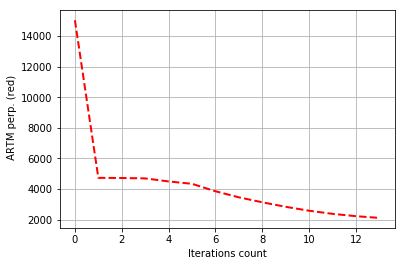

In [124]:
# посмотрим на качество
print_measures(model_artm)

Перплексия должна снижаться. Если график выровнился и больше не меняется - модель сошлась. Обычно перплексия хорошей модели около 200-1000. На таком небольшом количестве данных возможно такого значения достичь не получится.

In [125]:
# посмотрим на темы
for topic_name in model_artm.topic_names[:10]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

topic_0: 
пират
капитан
дверь
страх
душа
словно
дьявол
пиратский
твой
рука
---------
topic_1: 
атака
уязвимость
устройство
ноутбук
злоумышленник
вредоносный
защита
доллар
атаковать
уязвимый
---------
topic_2: 
человек
лекция
курс
книга
день
час
сказать
говорить
слово
хороший
---------
topic_3: 
процесс
результат
решение
являться
количество
база
задача
следующий
использование
связь
---------
topic_4: 
процессор
инструкция
регистр
память
архитектура
ассемблер
битный
программа
компьютер
такт
---------
topic_5: 
устройство
ключ
модуль
аппаратный
pin
power
управление
подпись
доступ
подключать
---------
topic_6: 
пользователь
ваш
сайт
вопрос
хороший
статья
хотеть
задача
разный
использование
---------
topic_7: 
sec
sum
сессия
скорость
трафик
пропускной
задержка
пакет
способность
потеря
---------
topic_8: 
страница
текст
перевод
ошибка
писать
окно
ссылка
код
написать
часть
---------
topic_9: 
точка
объект
часть
вершина
программа
второй
глава
алгоритм
некоторый
aux
---------


In [126]:
import copy
texts_copy = copy.copy(texts)

**н-граммы**

In [127]:
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.3, 
                           common_terms=set(stopwords.words('russian'))) # можно указать слова, которые 
                                                                         # не будут учитываться
p = gensim.models.phrases.Phraser(ph)
ngrammed_habr_texts = p[texts]

In [128]:
f = open('habr_texts_ngr.vw', 'w')

for i, text in enumerate(ngrammed_habr_texts):
    c = Counter(text)
    doc = 'doc_' + str(i) + ' '
    vw_text = ' '.join([x + ':' + str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()

In [129]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts_ngr.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                        batch_size=1000) # размер батча, подбирайте под свою память

In [130]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

In [131]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

In [132]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)

artm.Dictionary(name=eb4124ef-f069-46ee-8628-d4093f51cba9, num_entries=19045)

In [133]:
dictionary.save_text('dict_ngr.txt')

In [134]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [135]:
# инициализурем модель словарем
model_artm.initialize(dictionary=dictionary, )

In [136]:
# добавляем метрики
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

In [137]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 5574.637 (ARTM)


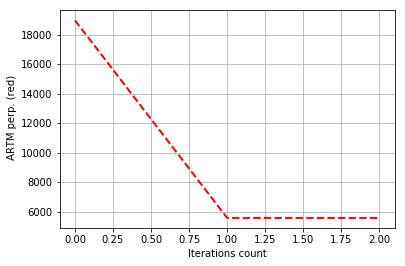

In [138]:
# посмотрим, что стало с моделью
# если график сильно падал на последних итерациях, то можно прогнать обучение ещё несколько раз 
# (не добавляя другие регуляризаторы)
print_measures(model_artm)

In [139]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [140]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [141]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.829 ARTM)
Sparsity Theta: 0.120 (ARTM)
Kernel contrast: 0.278 (ARTM)
Kernel purity: 0.239 (ARTM)
Perplexity: 2793.083 (ARTM)


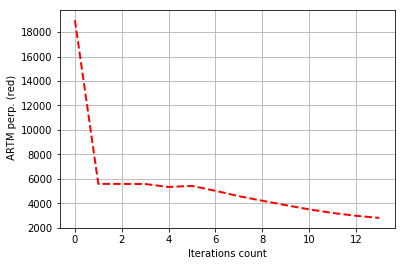

In [142]:
# посмотрим на качество
print_measures(model_artm)

**Перебор значений регуляризаторов**

In [143]:
num_topics = [50, 200, 300, 500]
tau = [0.01, 0.1, 0.15, 0.5]

Посмотрим на параметр `tau`, при этом возьмем кол-во тем = 300, а также изменим значение параметра `num_collection_passes` с 3 на 5:

0.01
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.001 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 5310.341 (ARTM)


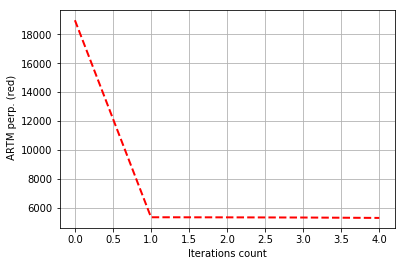

0.1
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 5561.088 (ARTM)


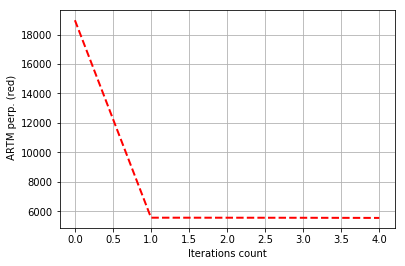

0.15
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 5733.778 (ARTM)


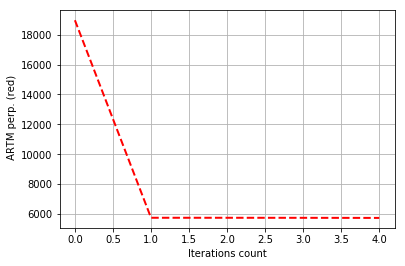

0.5
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 6918.018 (ARTM)


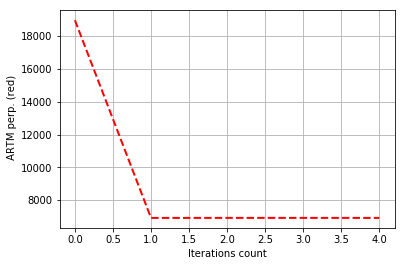

In [144]:
for value in tau:
    model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(300)],

                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=value, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 300)]),

                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=value, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 300)])
                                    ]
                        )
    model_artm.initialize(dictionary=dictionary, )

    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                        dictionary=dictionary))
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
    model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

    model_artm.num_document_passes = 2
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
    print(value)
    print_measures(model_artm)

Таким образом, далее будем работать с `tau=0.01`

`num_topics`

50
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.075 (ARTM)
Kernel purity: 0.002 (ARTM)
Perplexity: 5290.099 (ARTM)


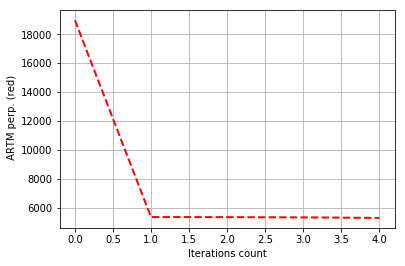

200
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.003 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 5301.029 (ARTM)


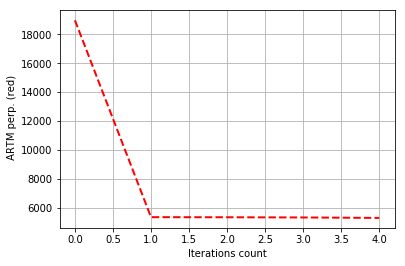

300
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.001 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 5310.341 (ARTM)


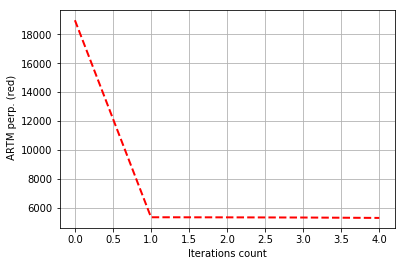

500
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 5322.930 (ARTM)


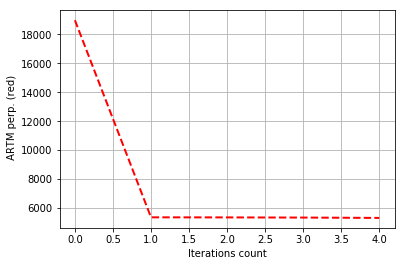

In [145]:
for value in num_topics:
    model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(value)],

                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.01, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, value)]),

                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.01, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, value)])
                                    ]
                        )
    model_artm.initialize(dictionary=dictionary, )

    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                        dictionary=dictionary))
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
    model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

    model_artm.num_document_passes = 2
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
    print(value)
    print_measures(model_artm)

`num_topics` = 50

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.075 (ARTM)
Kernel purity: 0.002 (ARTM)
Perplexity: 5290.099 (ARTM)


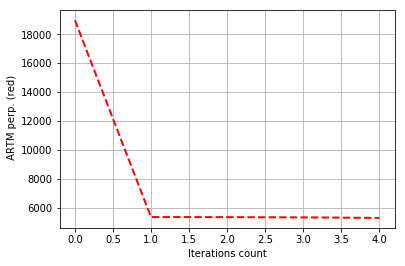

In [165]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(50)],

                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.01, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 50)]),

                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.01, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 50)])
                                    ]
                        )
model_artm.initialize(dictionary=dictionary, )

model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
print_measures(model_artm)

In [150]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 50)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 50)]))

In [151]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=5)

In [152]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=5)

Sparsity Phi: 0.912 ARTM)
Sparsity Theta: 0.060 (ARTM)
Kernel contrast: 0.431 (ARTM)
Kernel purity: 0.770 (ARTM)
Perplexity: 2849.682 (ARTM)


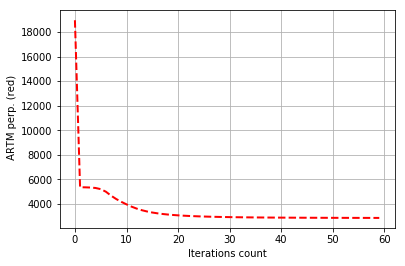

In [153]:
# посмотрим на качество
print_measures(model_artm)

**Предобработка + лучшие параметры - нграммы**

In [180]:
dictionary = artm.Dictionary()
dictionary.load_text('dict.txt')

In [206]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [207]:
model_artm.initialize(dictionary=dictionary, )

In [208]:
# добавляем метрики
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 4542.096 (ARTM)


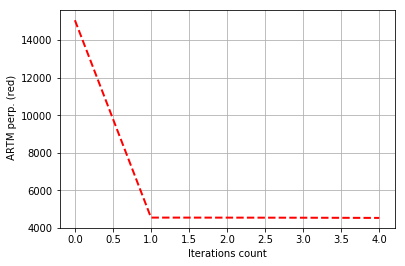

In [209]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
print_measures(model_artm)

In [189]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 50)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 50)]))

In [190]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=5)

In [191]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=5)

Sparsity Phi: 0.237 ARTM)
Sparsity Theta: 0.052 (ARTM)
Kernel contrast: 0.202 (ARTM)
Kernel purity: 0.328 (ARTM)
Perplexity: 2147.427 (ARTM)


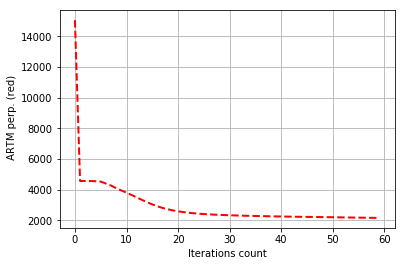

In [192]:
# посмотрим на качество
print_measures(model_artm)

**Изменим значение `tau_sparse`**

In [210]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 50)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.1, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 50)]))

In [211]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=5)

In [212]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=5)

Sparsity Phi: 0.183 ARTM)
Sparsity Theta: 0.042 (ARTM)
Kernel contrast: 0.218 (ARTM)
Kernel purity: 0.338 (ARTM)
Perplexity: 2079.903 (ARTM)


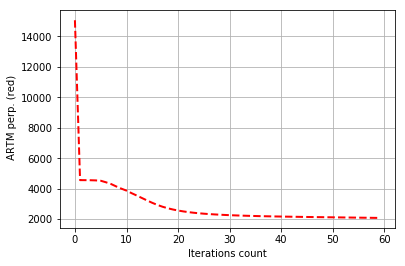

In [213]:
# посмотрим на качество
print_measures(model_artm)

Получили лучший результат.

In [195]:
# посмотрим на темы
for topic_name in model_artm.topic_names[:30]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

topic_0: 
состояние
механизм
state
иерархия
изменение
режим
сохранять
активный
изменяться
поведение
---------
topic_1: 
безопасность
защита
атака
письмо
уязвимость
защищать
злоумышленник
служба
угроза
информация
---------
topic_2: 
книга
курс
ребенок
навык
студент
обучение
школа
читать
лекция
учиться
---------
topic_3: 
событие
канал
оператор
номер
текущий
вызов
передавать
секунда
звонок
определенный
---------
topic_4: 
память
ядро
процессор
производительность
оптимизация
инструкция
байт
бит
intel
регистр
---------
topic_5: 
модуль
блок
управление
контроллер
использоваться
управлять
набор
зависимость
дополнительный
стандартный
---------
topic_6: 
ваш
дизайн
выбирать
хотеть
хороший
помогать
совет
дизайнер
тема
предлагать
---------
topic_7: 
задача
команда
выполнять
менеджер
цель
оценка
планирование
процесс
результат
выполнение
---------
topic_8: 
клиент
перевод
вопрос
заявка
crm
локализация
переводить
отвечать
клиентский
контакт
---------
topic_9: 
алгоритм
точка
координата
дерево
линия

**3 темы:**

**topic_13:**
цена
товар
продажа
стоимость
покупка
магазин
заказ
покупатель
скидка
купить

**topic_22:**
сообщение
отправлять
бот
отправка
друг
чат
telegram
общение
приходить
мессенджер

**topic_26:**
исследование
мозг
ученый
исследователь
говорить
эксперимент
изучать
животное
обнаруживать
результат

**Таким образом:**

- изменили предобработку и почистили словарь
- подобрали оптимальное количество тем (`num_topics=50`)
- подобрали оптимальное значение `tau` (`tau=0.01`)
- подобрали оптимальное значение `tau_sparse` (`tau=-0.1`)
- подобрали оптимальное значение `num_collection_passes` (`num_collection_passes=5`)
- при уменьшении значений `Phi` и `Theta` качество ухудшается

**Лучший результат**

`Sparsity Phi: 0.183 (ARTM)
Sparsity Theta: 0.042 (ARTM)
Kernel contrast: 0.218 (ARTM)
Kernel purity: 0.338 (ARTM)
Perplexity: 2079.903 (ARTM)`